# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import torch_optimizer
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
import common as com
import pytorch_modeler as modeler
#from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

In [4]:
#model = timm.create_model('efficientnet_b1', pretrained=True)
#3, 320, 320
#name: (channel_multiplier, depth_multiplier, resolution, dropout_rate)
#(1.4, 1.8, 380, 0.4)

In [5]:
#model.blocks[0][0]

## load config and set logger

In [6]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [7]:
# Setting seed
modeler.set_seed(42)

In [8]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/domain_adaptation/IDNN/exp5/config.yaml'

In [9]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [10]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths + dev_train_target_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths + add_dev_target_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3026, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9


In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

# load data

In [14]:
all_data = pd.read_pickle(f'/media/hiroki/HDD1TB/research/DCASE_experiments/domain_adaptation/IDNN/exp5/extraction_features/{machine_types[0]}_feature.pkl')

In [15]:
all_data['feature'] = torch.flatten(all_data['feature'], 1, 2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [20]:
np.where(all_data['section_label'] == 0)[0]

array([     0,      1,      2, ..., 927924, 927925, 927926])

In [24]:
secs = all_data['section_label']
sec = 0
tgt_idx = np.where(all_data['domain_label'] == 1)[0]
# secのindexを抽出
sec_idx = np.where(secs == sec)[0]
# 積集合 (tgtかつhoge section)
sec_tgt_idx = list(set(tgt_idx) & set(sec_idx))
# 差集合
sec_src_idx = list(set(sec_idx) - set(sec_tgt_idx))

In [26]:
len(sec_src_idx)

309000

# PCA

# UMAP

In [28]:
from umap import UMAP

In [ ]:
model = UMAP(random_state=42)
embedding_var = model.fit_transform(all_data['feature'][sec_src_idx])

/home/hiroki/anaconda3/envs/dcase2021_task2/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


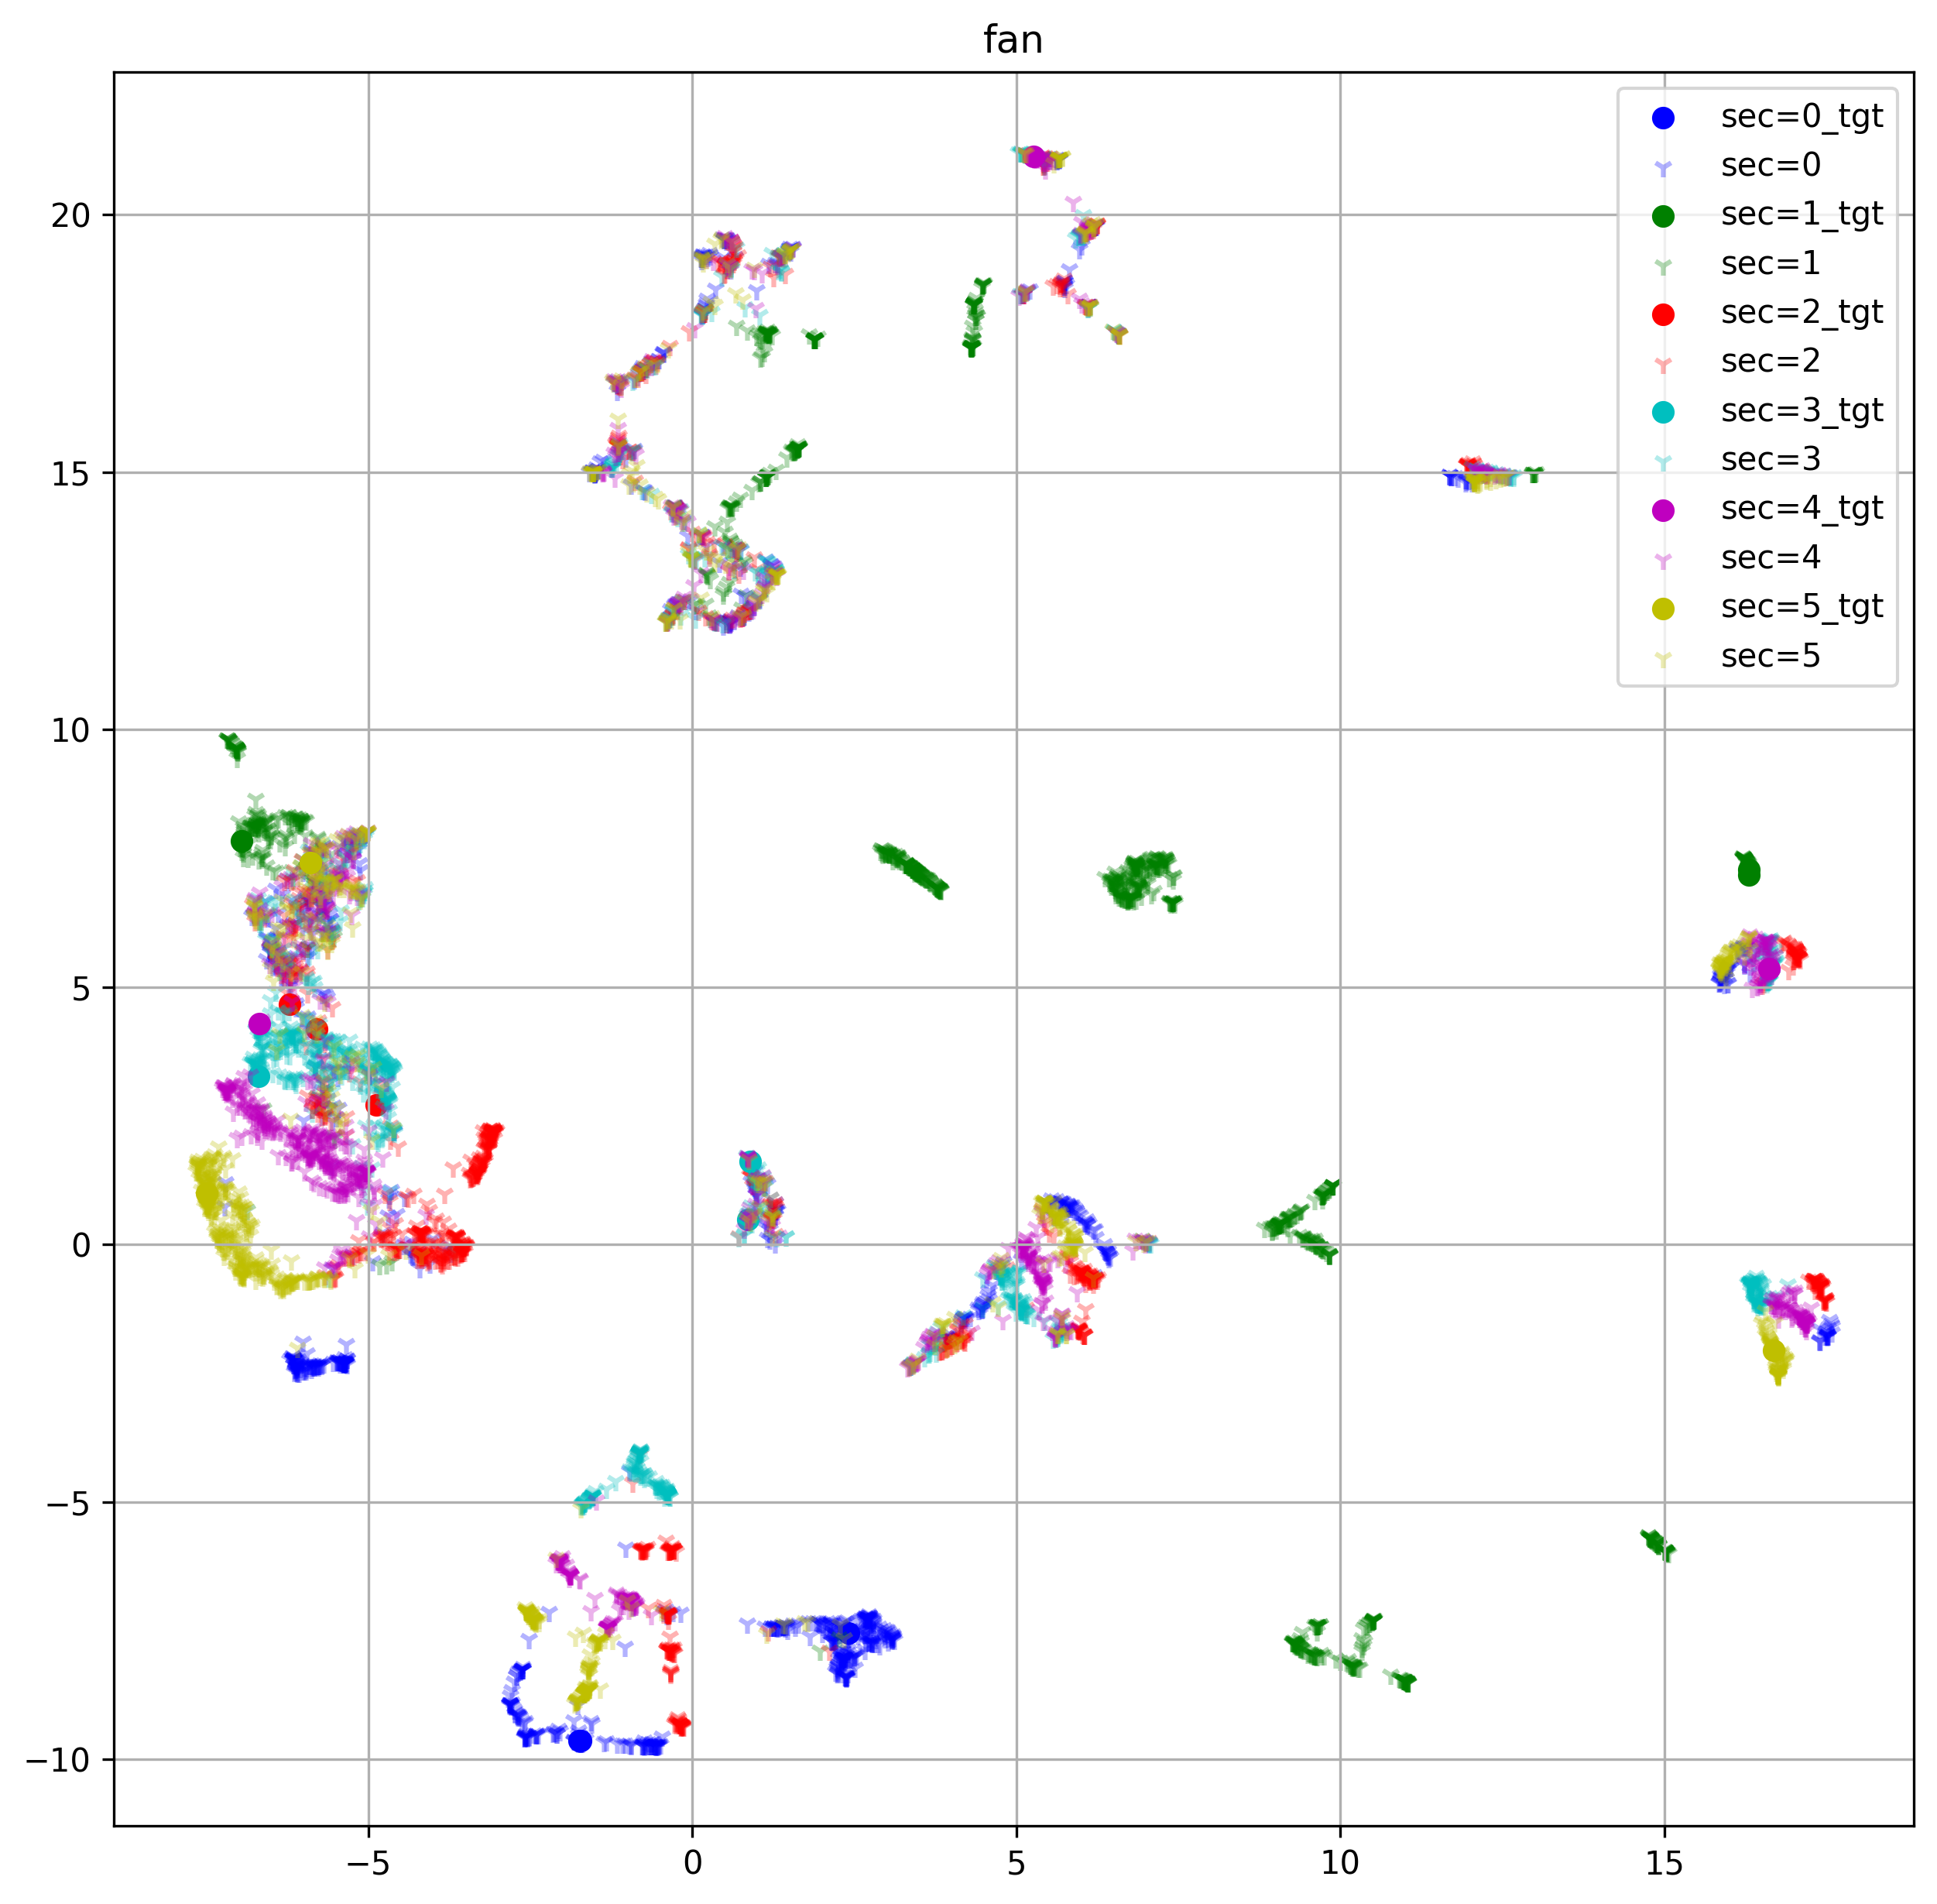

In [30]:
colors = ['b','g','r','c','m','y']
# model = UMAP(random_state=42)
# embedding_var = model.fit_transform(pca_feat)
# 結果を二次元でプロットする
fig = plt.figure(figsize=(10,10), dpi=300)
secs = all_data['section_label']
# tgtのindexを取得
tgt_idx = np.where(all_data['domain_label'] == 1)[0]
#label = output_dicts['train']['label']
embedding_x = embedding_var[:, 0]
embedding_y = embedding_var[:, 1]

colors = ['b','g','r','c','m','y']
for sec in np.unique(secs):
    # secのindexを抽出
    sec_idx = np.where(secs == sec)[0]
    # 積集合 (tgtかつhoge section)
    sec_tgt_idx = list(set(tgt_idx) & set(sec_idx))
    # tgt
    plt.scatter(embedding_x[sec_tgt_idx],
                embedding_y[sec_tgt_idx],
                label=f'sec={sec}_tgt',
                c=colors[sec])
    # src
    # 差集合
    sec_src_idx = list(set(sec_idx) - set(sec_tgt_idx))
    plt.scatter(embedding_x[sec_src_idx],
                embedding_y[sec_src_idx],
                label=f'sec={sec}',
                c=colors[sec],
                alpha=0.3,
                marker='1')#tri_down

# グラフを表示する
#loss = output_dicts['train']['loss']
plt.title(f'{machine_types[0]}')
plt.grid()
plt.legend()
plt.show()
#fig.savefig(f'./img/{machine_types[0]}_train_shift_embedding.png')

# train

In [ ]:
output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
# umap
model = UMAP(random_state=42, n_components=100)
embedding_var_tr = model.fit_transform(output_dicts['train']['feature'])
embedding_var_val_src = model.fit_transform(output_dicts['val_src']['feature'])
embedding_var_val_tgt = model.fit_transform(output_dicts['val_tgt']['feature'])

In [ ]:
per_sec_tr = []
sec_label = output_dicts['train']['section_label']
for section in range(6):
    sec_idx = np.where(sec_label == section)
    per_sec_tr.append(embedding_var_tr[sec_idx])

In [ ]:
per_sec_src = []
sec_label = output_dicts['val_src']['section_label']
for section in range(6):
    sec_idx = np.where(sec_label == section)
    per_sec_src.append(embedding_var_val_src[sec_idx])

In [ ]:
# per_sec_tgt = []
sec_label = output_dicts['val_tgt']['section_label']
for section in range(6):
    sec_idx = np.where(sec_label == section)
    per_sec_tgt.append(embedding_var_val_tgt[sec_idx])

In [ ]:
per_sec_tr[0][:,0]

In [ ]:
from scipy.spatial.distance import cdist, pdist

In [ ]:
cdist(per_sec_tr[0], per_sec_tr[1])

# n=100

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_tr[i]).mean())

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_src[i]).mean())

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_tgt[i]).mean())

# n=10

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_tr[i], '').mean())

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_src[i]).mean())

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_tgt[i]).mean())

# n=2

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_tr[i]).mean())

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_src[i]).mean())

In [ ]:
for i in range(len(per_sec_tr)):
    print(i)
    print(cdist(per_sec_tr[0], per_sec_tgt[i]).mean())

In [ ]:
for i in range(len(per_sec_src)):
    print(i)
    print(cdist(per_sec_src[0], per_sec_src[i]).mean())

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cdist(per_sec_tr[0], per_sec_src[1]), aspect='auto')
plt.colorbar()

In [ ]:
KLD(per_sec_src[0], per_sec_tgt[5])

for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['train']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10))
    secs = com.get_section_types(output_dicts['train']['wav_name'])
    label = output_dicts['train']['label']
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    for sec in np.unique(secs):
        plt.scatter(embedding_x[secs == sec],
                    embedding_y[secs == sec],
                    label=f'sec={sec}')

    # グラフを表示する
    loss = output_dicts['train']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_train_embedding.png')

# train shift

In [ ]:
colors = ['b','g','r','c','m','y']
for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['train']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10), dpi=300)
    secs = com.get_section_types(output_dicts['train']['wav_name'])
    # tgtのindexを取得
    tgt_idx = np.where(output_dicts['train']['domain_label'] == 1)[0]
    label = output_dicts['train']['label']
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    
    for sec in np.unique(secs):
        # secのindexを抽出
        sec_idx = np.where(secs == sec)[0]
        # 積集合 (tgtかつhoge section)
        sec_tgt_idx = list(set(tgt_idx) & set(sec_idx))
        # tgt
        plt.scatter(embedding_x[sec_tgt_idx],
                    embedding_y[sec_tgt_idx],
                    label=f'sec={sec}_tgt',
                    c=colors[sec])
        # src
        # 差集合
        sec_src_idx = list(set(sec_idx) - set(sec_tgt_idx))
        plt.scatter(embedding_x[sec_src_idx],
                    embedding_y[sec_src_idx],
                    label=f'sec={sec}',
                    c=colors[sec],
                    alpha=0.3,
                    marker='1')#tri_down
        
    # グラフを表示する
    loss = output_dicts['train']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_train_shift_embedding.png')

# valid_src

In [ ]:
colors = ['b','g','r','c','m','y']
for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['val_src']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10), dpi=300)
    secs = com.get_section_types(output_dicts['val_src']['wav_name'])
    # tgtのindexを取得
    tgt_idx = np.where(output_dicts['val_src']['domain_label'] == 1)[0]
    # anomalyのindexを取得
    label = output_dicts['val_src']['label']
    ano_idx = np.where(label == 1)[0]
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    
    for sec in np.unique(secs):
        # secのindexを抽出
        sec_idx = np.where(secs == sec)[0]
        # 積集合 (tgtかつhoge section)
        sec_ano_idx = list(set(ano_idx) & set(sec_idx))
        # anomaly
        plt.scatter(embedding_x[sec_ano_idx],
                    embedding_y[sec_ano_idx],
                    label=f'sec={sec}_anomaly',
                    alpha=0.3,
                    c=colors[sec])
        # src
        # 差集合 (normal)
        sec_normal_idx = list(set(sec_idx) - set(sec_ano_idx))
        plt.scatter(embedding_x[sec_normal_idx],
                    embedding_y[sec_normal_idx],
                    label=f'sec={sec}_normal',
                    c=colors[sec],
                    alpha=0.6,
                    marker='1')#tri_down
        
    # グラフを表示する
    loss = output_dicts['val_src']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_valsrc_DeepRepresentation.png')

# valid_tgt

In [ ]:
colors = ['b','g','r','c','m','y']
for machine_type in machine_types:
    output_dicts = pd.read_pickle(f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl')
    # umap
    model = UMAP(random_state=42)
    embedding_var = model.fit_transform(output_dicts['val_tgt']['feature'])
    # 結果を二次元でプロットする
    fig = plt.figure(figsize=(10,10), dpi=300)
    secs = com.get_section_types(output_dicts['val_tgt']['wav_name'])
    # tgtのindexを取得
    tgt_idx = np.where(output_dicts['val_tgt']['domain_label'] == 1)[0]
    # anomalyのindexを取得
    label = output_dicts['val_tgt']['label']
    ano_idx = np.where(label == 1)[0]
    embedding_x = embedding_var[:, 0]
    embedding_y = embedding_var[:, 1]
    
    for sec in np.unique(secs):
        # secのindexを抽出
        sec_idx = np.where(secs == sec)[0]
        # 積集合 (tgtかつhoge section)
        sec_ano_idx = list(set(ano_idx) & set(sec_idx))
        # anomaly
        plt.scatter(embedding_x[sec_ano_idx],
                    embedding_y[sec_ano_idx],
                    label=f'sec={sec}_anomaly',
                    alpha=0.3,
                    c=colors[sec])
        # src
        # 差集合 (normal)
        sec_normal_idx = list(set(sec_idx) - set(sec_ano_idx))
        plt.scatter(embedding_x[sec_normal_idx],
                    embedding_y[sec_normal_idx],
                    label=f'sec={sec}_normal',
                    c=colors[sec],
                    alpha=0.6,
                    marker='1')#tri_down
        
    # グラフを表示する
    loss = output_dicts['val_tgt']['loss']
    plt.title(f'{machine_type}, loss = {loss}')
    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'./img/{machine_type}_valtgt_DeepRepresentation.png')